# Homework 5

> I pledge my Honor that I have abided by the Stevens Honor System. - Joshua Schmidt

## Question 1

Please explain the pros and cons of Instance-Based Learning and Model-Based Learning
respectively

Instance based learning algorithms use the entire dataset for the given model. The training data cannot be discarded after the model is trained, because this data is an integral part of the model. One classic example is the K-Nearest Neighbors (KNN) algorithm, which looks at the training data to find the nearest k neighbors to a given input in a feature vector space. Model-based learning algorithms are more commonly used, and constitute most supervised-learning models.These algorithms use training data to build a model with learned parameters. Some common eamples include a neural-network, and Support Vector Machines (SVM). If there's a lot of training data, it may make sense to go with model-based learning, since you can discard the training that when you are done. The model can be much smaller than with instance-based learning. Generating an output from model-based is also generally faster, and does not necessarily scale with the size of the training data (unlike instance-based). However, instance-based models are usually easier to build and faster to train, and may have good enough results for a given task.

Please draw the diagram of Convolutional Neural Networks (CNN). Then explain the
functionality of each layer of CNN. Name several latest algorithms of CNN (e.g., AlexNet
etc.).

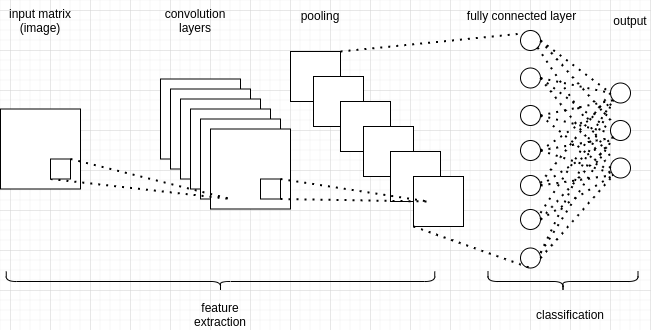

In [3]:
from IPython.display import Image
Image(filename='cnn_architecture.png')

There are three different types of layers in a CNN - convolutional, pooling, and fully-connected layers. The input layer converts an image file (CNNs are usually used for images) to a matrix. The convolution layers run 2d convolutions over the input layer, and an activation function is used to connct the layer to the pooling layer. The activation function is elementwise, mapped to individual nerons in the network. The pooling layer takes the output of the convolution and downsamples it, reducing the dimensionality so that the feature data is ready for classification. The fully connected layers then perform the classification, and is the same as a standard ANN. Some CNN algorithms include LeNet-5, AlexNet, Xception, and ResNet-50, among others.

Source: https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d

When training deep networks using Backpropagation, one difficulty is so-called
“diffusion of gradient”, i.e., the error will attenuate as it propagates to early layers. Please explain how to address this problem.

Any solution to the vanishing gradient problem would involve decreasing the attenuation of the error as it propogates down layers when training. With an activation layer like sigmoid being used, the gradient decrease is exponential. The easiest solution is to use  a different activation function, such as ReLU, which does not have a smll derivative, and therefore will not cause the error to attenuate as much. Batch normalization is another option, where the input data is normalized so that the input is not skewed towards the outer edges of the sigmoid function, and instead stays in the middle (where the derivative isn't as small). A third option is to use residual networks, which provide connections to earlier layers. These short circuits prevent the error from being attenuated by skipping layers that would have attenuated it.

## Question 2

Consider a learned hypothesis, h, for some Boolean concept. When h is tested on a set of 100 examples, it classifies 80 correctly. What is the 95% confidence interval for the true  error rate for $Error_D(h)$?

$.2 \pm 1.96\ \cdot\sqrt{\left(0.2\cdot\frac{\left(1-.2\right)}{100}\right)} = (0.1216, 0.2784)$

## Question 3

In [31]:
# imports
import numpy as np
import random
from math import ceil
from typing import Tuple, Callable
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
def generate_data(noise_scale: int, number_of_samples: int) -> Tuple[np.array, np.array]:
    """
    generate noisy polynomial data
    """
    x =  (25 * (np.random.rand(number_of_samples, 1) - 0.8))
    y = (5 * x + 20 * x**2 + 1 * x**3 + noise_scale * np.random.randn(number_of_samples, 1))
    # sort the values:
    x, y = map(lambda val: np.array(val), zip(*sorted(zip(x[:,0], y[:,0]), key=lambda elem: elem[0])))
    return x, y

x, y = generate_data(100, 100)

[ 0.9710437  19.31946988  5.65433777 14.1961698 ]


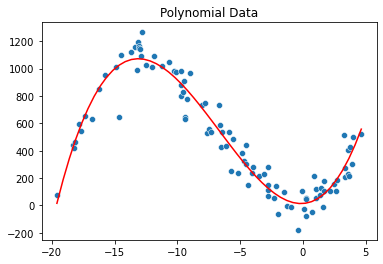

In [93]:
def get_prediction(x: np.array, y: np.array, degree: int) -> Tuple[np.array, np.array]:
    """
    get x and y values for polynomial fit
    """
    coefficients = np.polyfit(x, y, degree)
    print(coefficients)
    x_2 = np.linspace(min(x), max(x))
    polynomial = np.poly1d(coefficients)
    y_2 = polynomial(x_2)
    return x_2, y_2

def plot_polynomial(m: int, title: str) -> None:
    """
    plot polynomial data
    """
    sns.scatterplot(x=x, y=y).set(title=title)

    x_2, y_2 = get_prediction(x, y, m)
    plt.plot(x_2, y_2, color='r')
    plt.show()

plot_polynomial(3, 'Polynomial Data')

In [125]:
class GeneticAlgorithm:
    def __init__(self, pop_size: int = 50, max_degree: int = 3, max_pop: int = 1000,
                 rate: float = 0.01, wiggle: Tuple[float, float] = (0., 1.5), crossover: float = 0.4) -> None:
        self.population = np.random.random((max_pop, max_degree + 1)) * pop_size
        self.crossover = crossover
        self.wiggle = wiggle
        self.rate = rate
        self.percent_kept = 0.1
        self.coefficients = np.zeros(self.population.shape[0])
        self.loss = None

    def _loss(self, coefficients: np.array, x: np.array, y: np.array) -> float:
        """
        loss function
        """
        res = np.zeros(len(x))
        for i in range(res.shape[0]):
            output = 0
            for j in range(len(coefficients)):
                res[i] += coefficients[j] * (x[i] ** j)
        return abs(sum(y - res))

    def _run_mutations(self, new_gen: np.array) -> np.array:
        """
        run mutations
        """
        m, n = self.population.shape
        indexes_to_mutate = np.random.randint(low=0, high=m, size=(ceil(m * self.rate),))
        wiggle = np.random.uniform(low=self.wiggle[0], high=self.wiggle[1], size=(len(indexes_to_mutate),))
        coefficients_indexes_to_mutate = np.random.randint(low=0, high=n, size=(len(indexes_to_mutate),))
        for i, index_to_mutate in enumerate(coefficients_indexes_to_mutate):
            delta = new_gen[index_to_mutate, coefficients_indexes_to_mutate[i]] * wiggle[i]
            if not random.getrandbits(1):
                delta *= -1
            new_gen[index_to_mutate, coefficients_indexes_to_mutate[i]] += delta

    def _run_crossover(self, new_gen: np.array) -> np.array:
        """
        run crossover
        """
        m, n = self.population.shape
        num_crossover = ceil(m * self.crossover)
        if num_crossover % 2 != 0:
            num_crossover -= 1
        indexes_to_crossover = np.random.randint(low=0, high=m, size=(num_crossover,))
        crossover_pairs = np.array_split(indexes_to_crossover, num_crossover / 2)

        when_to_stop = int(n/2)
        for pair in crossover_pairs:
            elem1 = new_gen[pair[0], :]
            elem2 = new_gen[pair[1], :]
            temp = None
            temp = elem1[:when_to_stop].copy()
            elem1[:when_to_stop] = elem2[:when_to_stop]
            elem2[:when_to_stop] = temp
            new_gen[pair[0], :] = elem1
            new_gen[pair[1], :] = elem2

    def fit(self, x: np.ndarray, y: np.ndarray, max_iter: int = 500, threshold: float = 500.) -> None:
        """
        get coefficients
        """
        m, n = self.population.shape
        self.coefficients = np.zeros(n)
        self.loss = None

        for gen in range(max_iter):
            print(f'gen {gen}')
            loss_scores = np.zeros(m)
            for i in range(m):
                curr_coefficients = self.population[i, :]
                loss_scores[i] = self._loss(curr_coefficients, x, y)
                if loss_scores[i] <= threshold:
                    self.coefficients = curr_coefficients
                    return

            best_index = np.argpartition(loss_scores, 1)[:1]
            self.coefficients = self.population[best_index, :]
            self.best_loss = loss_scores[best_index]

            kept = int(m * self.percent_kept)
            kept_indexes = np.argpartition(loss_scores, kept)[:kept]

            new_gen = np.zeros_like(self.population)
            new_gen_indexes = np.array_split(np.arange(m), len(kept_indexes))
            for i, curr_batch in enumerate(new_gen_indexes):
                new_gen[curr_batch, :] = self.population[kept_indexes[i], :]

            self._run_mutations(new_gen)

            self._run_crossover(new_gen)

            self.population = new_gen

In [126]:
algo = GeneticAlgorithm()
algo.fit(x, y)

best_coefs = algo.coefficients
print(f"best coefficients: {best_coefs}")

gen 0
gen 1
best coefficients: [27.01806129 43.35043597 42.81292509  2.52735062]


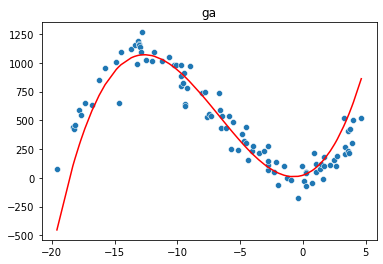

In [102]:
sns.scatterplot(x=x, y=y).set(title='ga')

y_2 = np.zeros(len(x))
for i, _ in enumerate(best_coefs):
    y_2 += best_coefs[i] * (x ** i)
plt.plot(x, y_2, color='r')
plt.show()

[-2.25914729e-03  9.05969440e-01  1.88943843e+01  6.22017889e+00
  1.82791215e+01]


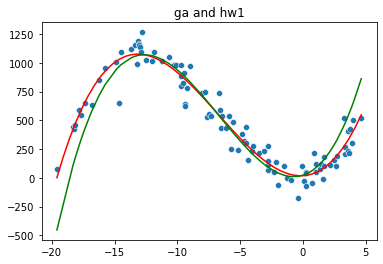

In [103]:
sns.scatterplot(x=x, y=y).set(title='ga and hw1')

x_2, y_2 = get_prediction(x, y, len(best_coefs))
plt.plot(x_2, y_2, color='r')

y_3 = np.zeros(len(x))
for i, _ in enumerate(best_coefs):
    y_3 += best_coefs[i] * (x ** i)

plt.plot(x, y_3, color='g')
plt.show()